In [2]:
import sys, os, pygmt, importlib, re, time
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_toolbox        import SeaIceToolbox
from datetime               import timedelta, date, datetime
from pathlib                import Path
from dask.distributed       import Client, LocalCluster
from dask.diagnostics       import ProgressBar
from pyproj                 import CRS, Transformer
from collections            import defaultdict
from scipy.interpolate      import interp1d
from matplotlib.offsetbox   import AnchoredOffsetbox, VPacker, TextArea
from tqdm                   import tqdm
from IPython.display        import Image, HTML, Video
import numpy                as np
import pandas               as pd
import xarray               as xr
import xesmf                as xe
import matplotlib.pyplot    as plt
import matplotlib.dates     as mdates
import matplotlib.animation as animation

In [ ]:
afim_name  = "elps-min"
dt0_str    = "1993-01-01"
dtN_str    = "1999-12-31"
SI_tools   = SeaIceToolbox(sim_name = afim_name,
                           dt0_str  = dt0_str,
                           dtN_str  = dtN_str)
_, CICE    = SI_tools.load_processed_cice( zarr_CICE = True )
CICE_ispd  = SI_tools.compute_ice_magnitude_from_ice_components_on_Bgrid( CICE , ivec_type="BT" )
CICE_SO    = CICE_ispd.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
G_CICE_SO  = {"lon": CICE_SO["TLON"].values, "lat": CICE_SO["TLAT"].values}

In [ ]:
aom2_name  = "AOM2-ERA5"
dt0_str    = "1993-01-01"
dtN_str    = "1999-12-31"
SI_tools   = SeaIceToolbox(sim_name = aom2_name,
                           dt0_str  = dt0_str,
                           dtN_str  = dtN_str)
_, AOM2    = SI_tools.load_processed_cice( zarr_CICE = True )
AOM2_ispd  = SI_tools.compute_ice_magnitude_from_ice_components_on_Bgrid( AOM2 , ivec_type="BT" )
AOM2_SO    = AOM2_ispd.isel(nj=SI_tools.hemisphere_dict['nj_slice'])

In [8]:
ispd_diff = xr.open_mfdataset("/g/data/gv90/da1339/SeaIce/OSI_SAF/ice_drift_455m/ice_speeds_and_differences_elps-min_AOM2-ERA5_*.nc")
print(ispd_diff)

<xarray.Dataset> Size: 51GB
Dimensions:      (time: 1821, nj: 540, ni: 1440)
Coordinates:
  * time         (time) datetime64[ns] 15kB 1994-01-01T12:00:00 ... 1998-12-3...
    TLON         (nj, ni) float32 3MB dask.array<chunksize=(540, 1440), meta=np.ndarray>
    TLAT         (nj, ni) float32 3MB dask.array<chunksize=(540, 1440), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Data variables:
    ispd_obs     (time, nj, ni) float64 11GB dask.array<chunksize=(61, 90, 240), meta=np.ndarray>
    ispd_CICE    (time, nj, ni) float32 6GB dask.array<chunksize=(73, 108, 288), meta=np.ndarray>
    ispd_AOM2    (time, nj, ni) float32 6GB dask.array<chunksize=(73, 108, 288), meta=np.ndarray>
    d_ispd_CICE  (time, nj, ni) float64 11GB dask.array<chunksize=(61, 90, 240), meta=np.ndarray>
    d_ispd_AOM2  (time, nj, ni) float64 11GB dask.array<chunksize=(61, 90, 240), meta=np.ndarray>
    d_ispd_sims  (time, nj, ni) float32 6GB dask.array<chunksize=(73, 108, 288), meta=np.ndarray>
    RMSE

In [ ]:
# search for all OSI-SAF
D_search  = Path(Path.home(),"seaice","OSI_SAF","ice_drift_455m","sh")
F_search  = "ice_drift_sh_ease2-750_cdr-v1p0_24h-*.nc"
P_found   = sorted(D_search.rglob(F_search))
# Prepare an empty list to collect daily datasets
DS        = []
# Loop over files
last_cice_time = pd.to_datetime(CICE_SO["time"].values[-1])
for i, F_ in tqdm(enumerate(P_found), desc="Working on OSI-SAF regridding", total=len(CICE_SO["time"].values)):
    osisaf = xr.open_dataset(P_found[270])
    dt_obs = pd.to_datetime(osisaf["time"].values[0])
    if dt_obs > last_cice_time:
        print(f"Stopping loop: reached {dt_obs}, beyond model end {last_cice_time}")
        break
    # Compute ice speed (in m/s)
    dt       = (osisaf["t1"] - osisaf["t0"]).astype("timedelta64[s]").astype(float)
    dt       = xr.where(dt == 0, np.nan, dt)
    disp_m   = np.sqrt(osisaf["dX"]**2 + osisaf["dY"]**2) * 1000  # km → m
    ispd_obs = (disp_m / dt).squeeze()
    ispd_obs.name = "ispd"
    ispd_obs.attrs["units"] = "m s-1"
    # Get time string
    dt_str = pd.to_datetime(ispd_obs.time.values).strftime("%Y-%m-%d")
    # Regridder
    # if i == 0:
    reG = xe.Regridder(ispd_obs, G_CICE_SO, method="bilinear", periodic=True, reuse_weights=False)
    ispd_obs_reG = reG(ispd_obs).compute()
    ispd_obs_reG = ispd_obs_reG.rename({"y": "nj", "x": "ni"})
    # Extract model values for the same day
    ispd_cice    = CICE_SO["ispd_BT"].sel(time=dt_str).compute()
    ispd_aom2    = AOM2_SO["ispd_BT"].sel(time=dt_str).compute()
    d_cice       = ispd_obs_reG - ispd_cice
    d_aom2       = ispd_obs_reG - ispd_aom2
    d_sims       =    ispd_aom2 - ispd_cice
    # Compute RMSEs
    rmse_cice = float(np.sqrt((d_cice**2).mean()))
    rmse_aom2 = float(np.sqrt((d_aom2**2).mean()))
    rmse_sims = float(np.sqrt((d_sims**2).mean()))
    # expand 2D to 3D
    ispd_obs_3d  = ispd_obs_reG.expand_dims("time")
    ispd_cice_3d = ispd_cice.expand_dims("time")
    ispd_aom2_3d = ispd_aom2.expand_dims("time")
    d_cice_3d    = d_cice.expand_dims("time")
    d_aom2_3d    = d_aom2.expand_dims("time")
    d_sims_3d    = d_sims.expand_dims("time")
    # Package into dataset
    daily_ds = xr.Dataset(data_vars = dict(ispd_obs   = (("time", "nj", "ni"), ispd_obs_3d.data, {"units": "m/s", 
                                                                                              "long_name": "OSI-SAF regridded"}),
                                           ispd_CICE  = (("time", "nj", "ni"), ispd_cice_3d.data, {"units": "m/s", 
                                                                                           "long_name": f"CICE6-SA {afim_name} ice speed"}),
                                           ispd_AOM2  = (("time", "nj", "ni"), ispd_aom2_3d.data, {"units": "m/s", 
                                                                                           "long_name": "ACCESS-OM2-025 ERA5 forced"}),
                                           d_ispd_CICE= (("time", "nj", "ni"), d_cice_3d.data, {"units": "m/s", 
                                                                                        "long_name": "obs - CICE"}),
                                           d_ispd_AOM2= (("time", "nj", "ni"), d_aom2_3d.data, {"units": "m/s", 
                                                                                        "long_name": "obs - AOM2"}),
                                           d_ispd_sims= (("time", "nj", "ni"), d_sims_3d.data, {"units": "m/s", 
                                                                                        "long_name": "AOM2 - CICE"}),
                                           RMSE_CICE  = (("time",), [rmse_cice], {"units": "m/s",
                                                                                  "long_name": "RMSE obs - CICE"}),
                                           RMSE_AOM2  = (("time",), [rmse_aom2], {"units": "m/s",
                                                                                  "long_name": "RMSE obs - AOM2"}),
                                           RMSE_sims  = (("time",), [rmse_sims], {"units": "m/s",
                                                                                  "long_name": "RMSE AOM2 - CICE"}),),
                          coords    = dict(time = ("time", [ispd_obs.time.values]),
                                           TLON = (("nj", "ni"), CICE_SO["TLON"].values),
                                           TLAT = (("nj", "ni"), CICE_SO["TLAT"].values),))
    DS.append(daily_ds)

In [ ]:
# Concatenate along time
DS_ispds = xr.concat(DS, dim="time")
P_nc     = Path(Path.home(),"seaice","OSI_SAF","ice_drift_455m",f"ice_speeds_and_differences_{afim_name}_and_{aom2_name}.nc")
P_nc.parent.mkdir(parents=True, exist_ok=True)
DS_ispds.to_netcdf(path     = P_nc,
                   mode     = "w",
                   format   = "NETCDF4",
                   encoding = {var: {"zlib": True, "complevel": 4} for var in DS_ispds.data_vars})

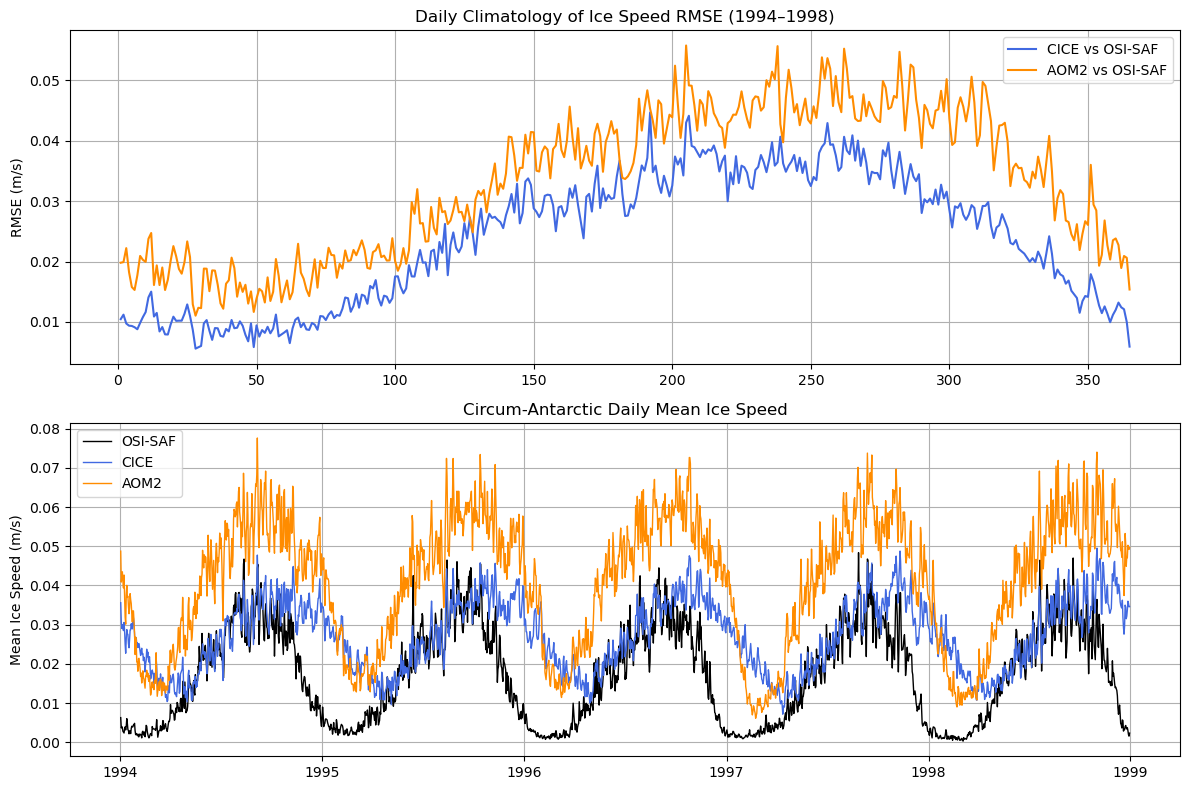

In [10]:
# Daily climatologies of RMSE
rmse_cice_clim = ispd_diff["RMSE_CICE"].groupby("time.dayofyear").mean("time")
rmse_aom2_clim = ispd_diff["RMSE_AOM2"].groupby("time.dayofyear").mean("time")

# Spatial averages (daily means) of observed and modeled speed
mean_obs  = ispd_diff["ispd_obs"].mean(dim=("nj", "ni"))
mean_cice = ispd_diff["ispd_CICE"].mean(dim=("nj", "ni"))
mean_aom2 = ispd_diff["ispd_AOM2"].mean(dim=("nj", "ni"))

# === Plotting ===
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

# RMSE climatology
axs[0].plot(rmse_cice_clim["dayofyear"], rmse_cice_clim, label="CICE vs OSI-SAF", color="royalblue")
axs[0].plot(rmse_aom2_clim["dayofyear"], rmse_aom2_clim, label="AOM2 vs OSI-SAF", color="darkorange")
axs[0].set_ylabel("RMSE (m/s)")
axs[0].set_title("Daily Climatology of Ice Speed RMSE (1994–1998)")
axs[0].legend()
axs[0].grid(True)

# Daily mean speeds
axs[1].plot(ispd_diff["time"], mean_obs, label="OSI-SAF", color="black", linewidth=1)
axs[1].plot(ispd_diff["time"], mean_cice, label="CICE", color="royalblue", linewidth=1)
axs[1].plot(ispd_diff["time"], mean_aom2, label="AOM2", color="darkorange", linewidth=1)
axs[1].set_ylabel("Mean Ice Speed (m/s)")
axs[1].set_title("Circum-Antarctic Daily Mean Ice Speed")
axs[1].legend()
axs[1].grid(True)

fig.tight_layout()
plt.show()

In [ ]:
ispd_diff = ispd_obs_reG - ispd_sim

In [ ]:
rmse = np.sqrt((ispd_diff**2).mean()).item()
print(f"RMSE: {rmse:.3f} m/s")

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(14, 5))
ispd_obs_reG.plot(ax=ax1)
ax1.set_title("Observed Ice Speed")
CICE_ispd["ispd_BT"].sel(time="1993-09-28").isel(nj=slice(0,540)).plot(ax=ax2)
ax2.set_title("Simulated Ice Speed")
ispd_diff.plot(ax=ax3)
ax3.set_title("Observed-Simulated")
plt.tight_layout()
plt.show()